# Lab Exercise I: Sampling and Reconstruction of Speech Signals




## 1. Implement sampling and quantization techniques for the given speech signals.

In [2]:
# 1. Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [3]:
speech_file = 'input.wav'

### a. Load and Plot the Time Domain Representation of the Original Speech Signal


In [ ]:
# Compute and print MSE between original and reconstructed-from-sampled signals
# Reconstruct to original timeline for a fair comparison
mse_by_rate = {}

# Ensure original speech is float for MSE
speech_float = speech.astype(np.float64)

for rate, sampled_signal in sampled_signals.items():
    t_sampled = sampled_times[rate]
    # Interpolate sampled signal back to original time grid
    rec_fn = interp1d(t_sampled, sampled_signal, kind='linear', bounds_error=False, fill_value="extrapolate")
    reconstructed = rec_fn(time).astype(np.float64)

    # Align lengths in case of tiny off-by-one due to rounding
    min_len = min(len(speech_float), len(reconstructed))
    mse = mean_squared_error(speech_float[:min_len], reconstructed[:min_len])
    mse_by_rate[rate] = mse

for rate in sorted(mse_by_rate.keys()):
    print(f"MSE at {rate/1000:.1f} kHz: {mse_by_rate[rate]:.6f}")



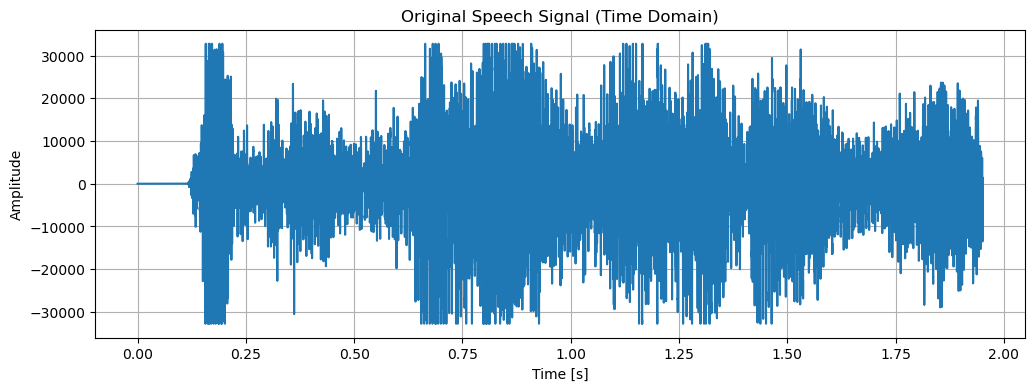

In [ ]:
# Read the speech signal (.wav file)
fs_orig, speech = wavfile.read(speech_file)
if speech.ndim > 1:   
    speech = speech[:, 0]

duration = len(speech) / fs_orig
time = np.linspace(0, duration, len(speech))

plt.figure(figsize=(12, 4))
plt.plot(time, speech)
plt.title('Original Speech Signal (Time Domain)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


### b. Sample the Speech Signal at Different Rates (8 kHz, 16 kHz, 44.1 kHz)

In [ ]:
# Define target sampling rates
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}
sampled_times = {}

# Resample the signal to each target rate using interpolation (avoids step=0 errors)
# Creates exactly rate * duration samples per target rate
interp_fn = interp1d(time, speech, kind='linear', bounds_error=False, fill_value="extrapolate")
for rate in sampling_rates:
    num_samples = int(np.floor(duration * rate))
    t_new = np.linspace(0, duration, num_samples, endpoint=False)
    sampled_signal = interp_fn(t_new)
    sampled_signals[rate] = sampled_signal
    sampled_times[rate] = t_new

### c. Plot the Sampled Speech Signal for Each Sampling Rate


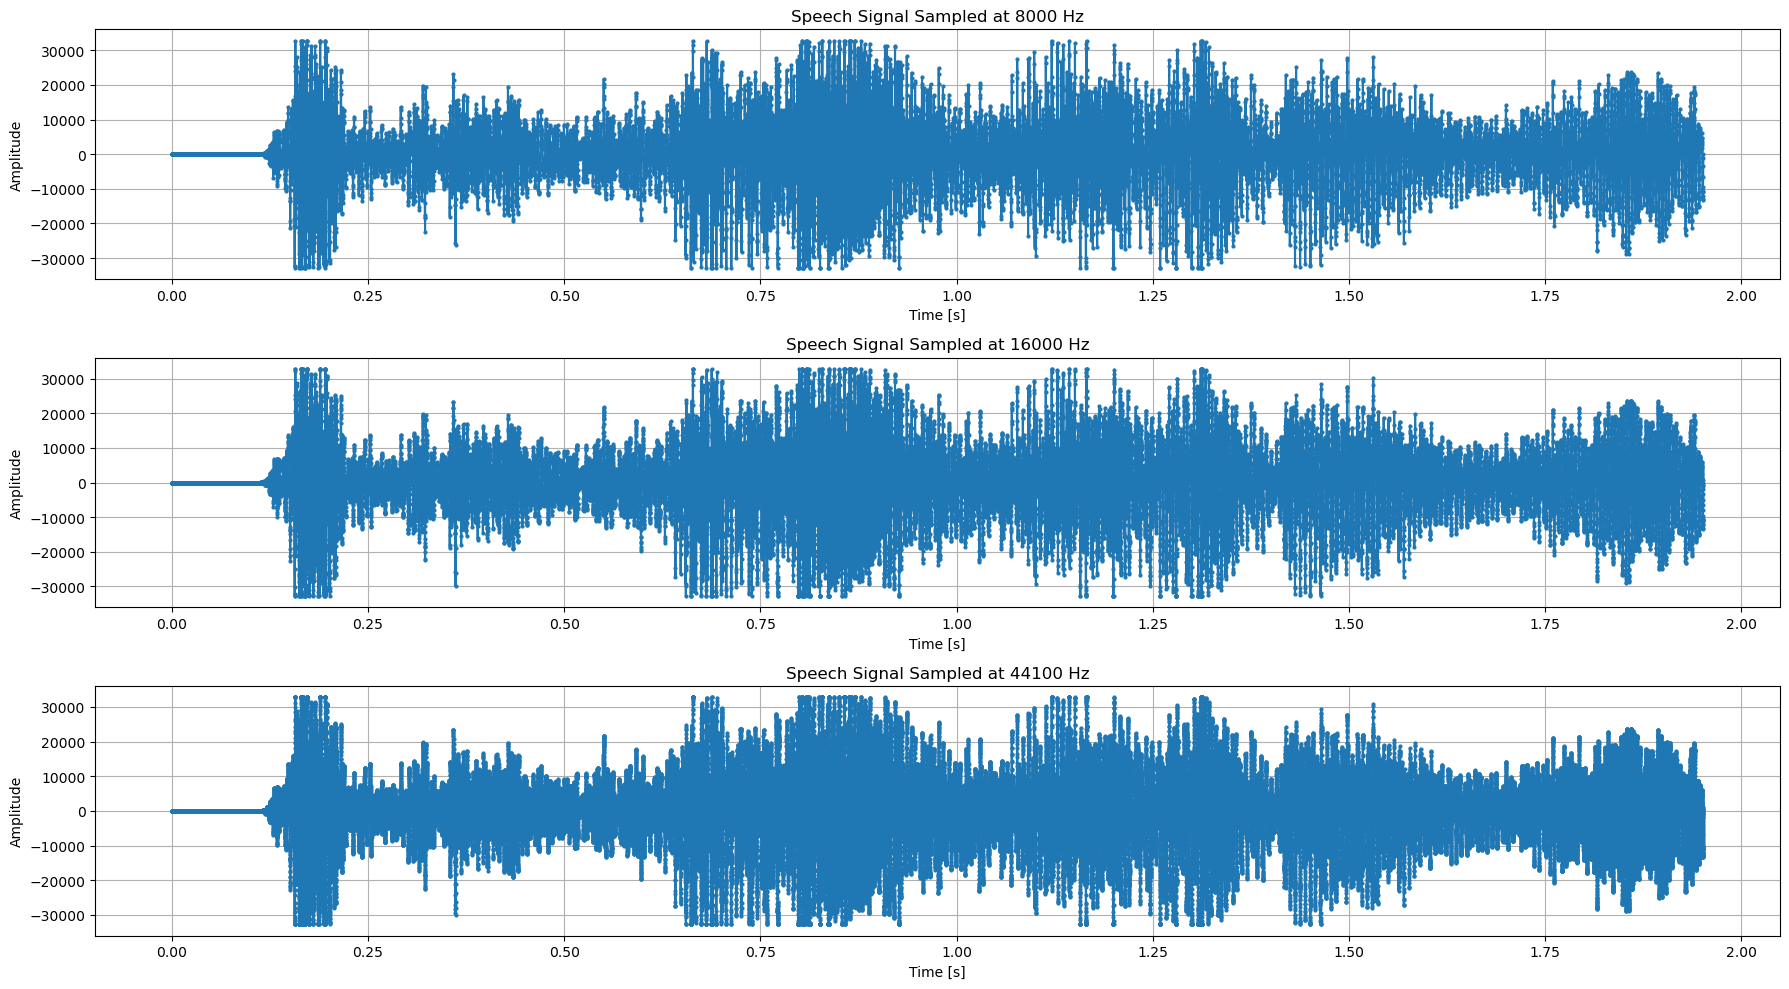

In [7]:
plt.figure(figsize=(18, 10))
for idx, rate in enumerate(sampling_rates):
    plt.subplot(3, 1, idx+1)
    plt.plot(sampled_times[rate], sampled_signals[rate], marker='o', linestyle='-', markersize=2)
    plt.title(f'Speech Signal Sampled at {rate} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()


### d. Reconstruct the Signal using:
- (i) Zero-order hold (nearest-neighbor interpolation)
- (ii) Linear interpolation


In [8]:
# Let's reconstruct using interpolation to original sampling instants

reconstructed_zero_order = {}
reconstructed_linear = {}
mse_zero_order = {}
mse_linear = {}

for rate in sampling_rates:
    # Take the sampled times and amplitudes
    t_sampled = sampled_times[rate]
    y_sampled = sampled_signals[rate]
    
    # (a) Zero-order hold (nearest-neighbor interpolation)
    f_zero_order = interp1d(t_sampled, y_sampled, kind='nearest', fill_value="extrapolate")
    rec_zero = f_zero_order(time)
    
    # (b) Linear interpolation
    f_linear = interp1d(t_sampled, y_sampled, kind='linear', fill_value="extrapolate")
    rec_linear = f_linear(time)
    
    reconstructed_zero_order[rate] = rec_zero
    reconstructed_linear[rate] = rec_linear
    
    # Mean Squared Error calculation
    mse_zero_order[rate] = mean_squared_error(speech.astype(float), rec_zero)
    mse_linear[rate] = mean_squared_error(speech.astype(float), rec_linear)


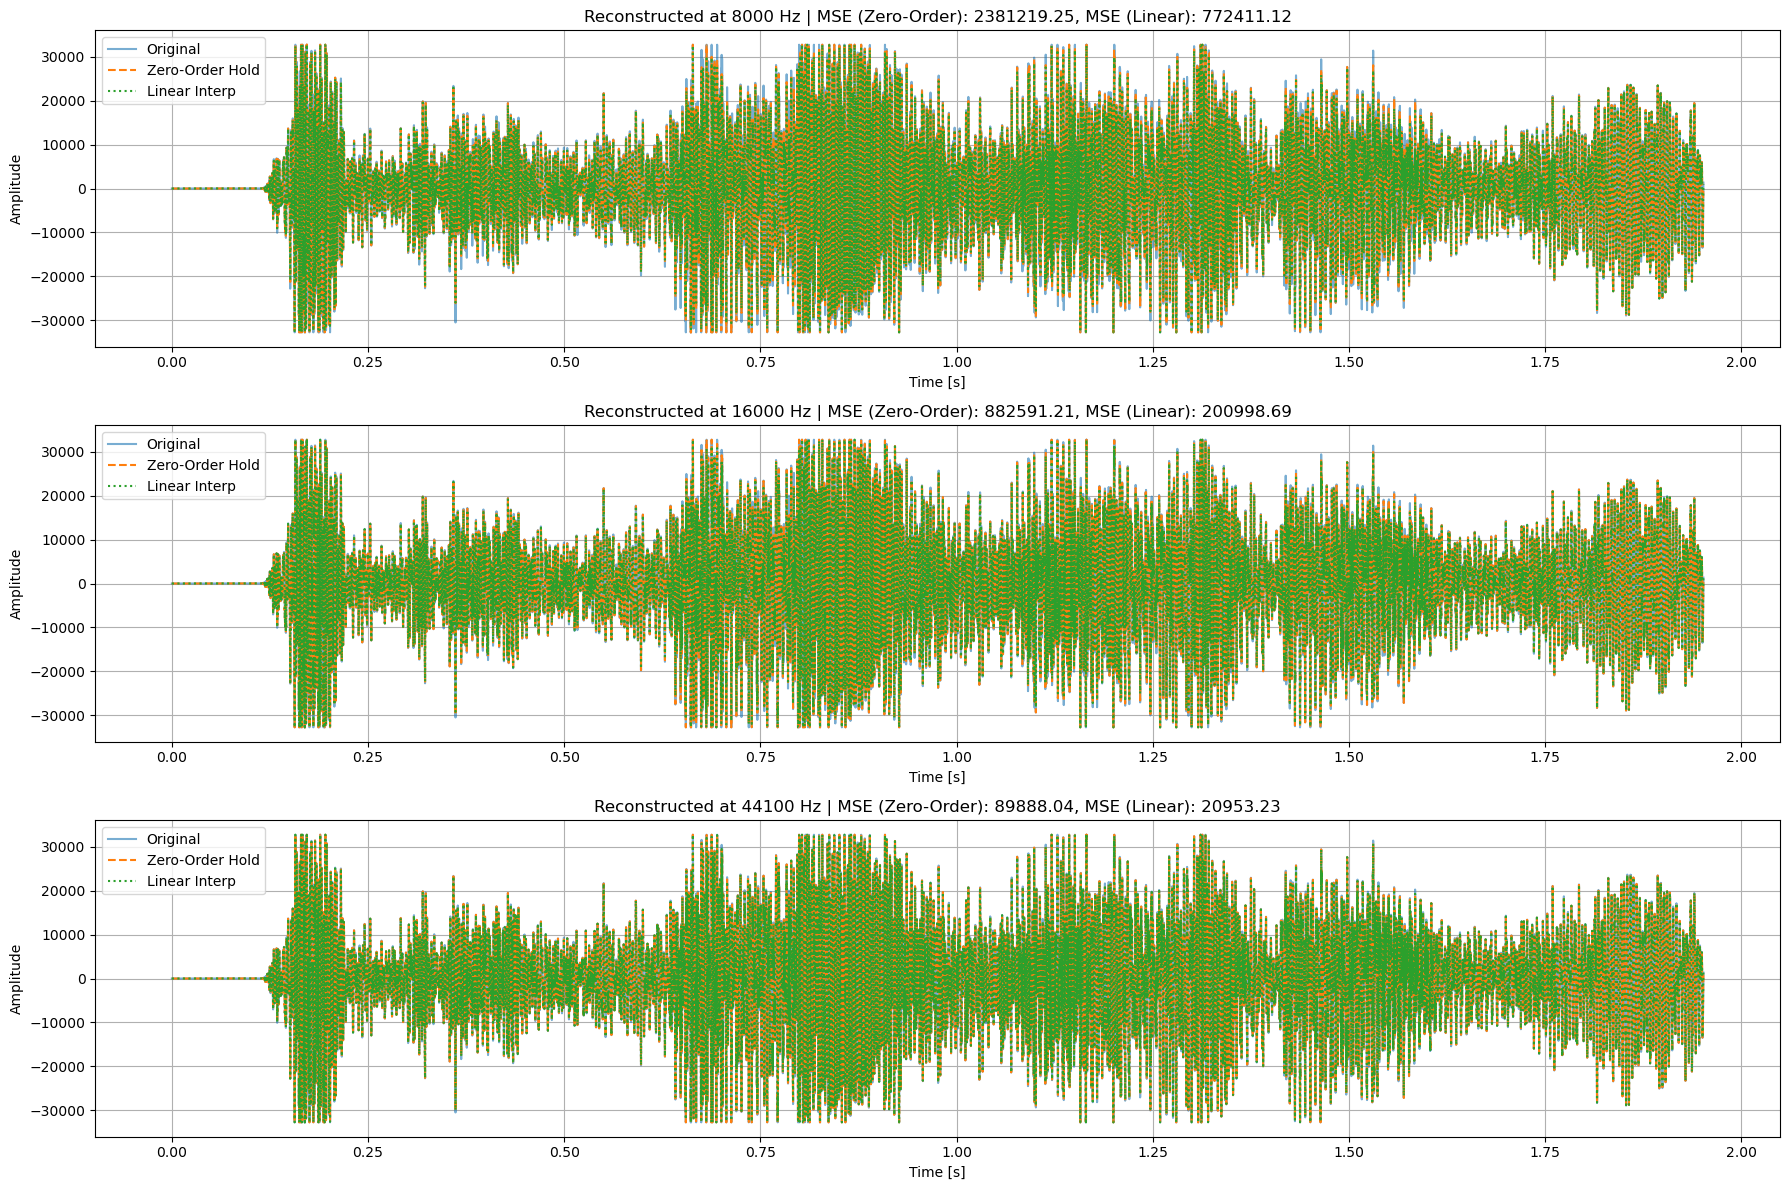

In [9]:
plt.figure(figsize=(18, 12))
for idx, rate in enumerate(sampling_rates):
    plt.subplot(len(sampling_rates), 1, idx+1)
    plt.plot(time, speech, label='Original', alpha=0.6)
    plt.plot(time, reconstructed_zero_order[rate], label='Zero-Order Hold', linestyle='--')
    plt.plot(time, reconstructed_linear[rate], label='Linear Interp', linestyle=':')
    plt.title(f'Reconstructed at {rate} Hz | MSE (Zero-Order): {mse_zero_order[rate]:.2f}, MSE (Linear): {mse_linear[rate]:.2f}')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()


## Inference

At **higher sampling rates** (such as 44.1 kHz), the reconstructed signals are more accurate, and both zero-order hold and linear interpolations yield lower MSE, meaning the reconstruction closely follows the original signal and preserves quality.
- At **lower sampling rates** (such as 8 kHz), the reconstructed signal is less faithful, especially with zero-order hold, which can sound more artificial and introduce more distortion.

**Linear interpolation** generally produces lower reconstruction errors (lower MSE) compared to zero-order hold.

---  
**Key Points:**
- Sampling below the Nyquist rate (half the highest frequency of the signal) causes loss of information (aliasing).
- Linear interpolation is usually preferable for smoother signal reconstruction.


## 2. Implement the source-filter model for a given speech signal and analyze the impact of sampling and reconstruction on the quality of the speech signal.

In [10]:
from scipy.signal import lfilter, freqz, firwin, sawtooth
from scipy.interpolate import interp1d

### a. Generate a synthetic speech signal using the source-filter model.

#### i. Create a source signal (e.g., a glottal pulse train for voiced sounds or white noise for unvoiced sounds).

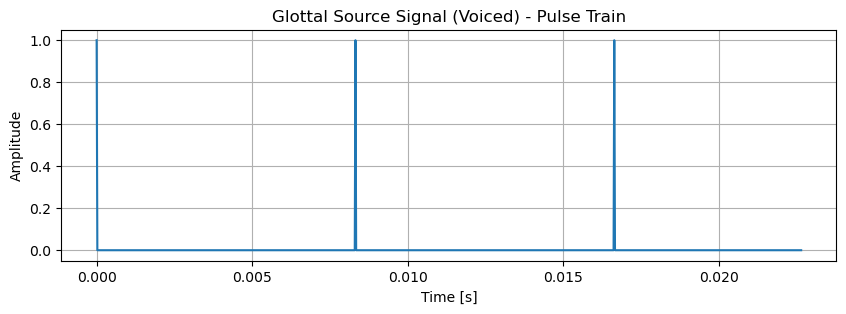

In [17]:
# Define parameters for the synthetic voice (voiced sound)
fs = 44100                       # Sampling frequency for ground truth
duration = 1.0                   # Duration in seconds
f0 = 120                         # Fundamental frequency (pitch), 120Hz - typical male voice

# Time axis
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# (i) Glottal pulse train (impulse train) for voiced sound
source_signal = np.zeros_like(t)
source_signal[::int(fs/f0)] = 1  # Impulses at every pitch period

plt.figure(figsize=(10, 3))
plt.plot(t[:1000], source_signal[:1000])
plt.title('Glottal Source Signal (Voiced) - Pulse Train')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


#### ii. Apply a filter that models the vocal tract, represented by an all-pole filter or an FIR filter with formants (resonances of the vocal tract).

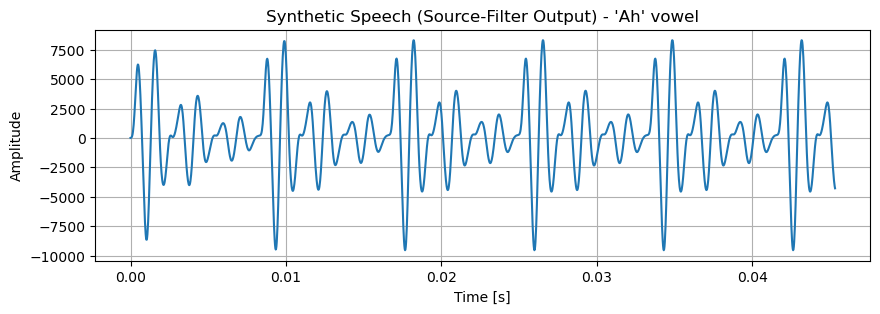

In [12]:
def formant_filter(fs, formant_freqs, bandwidths):
    # Compute poles for each formant
    a = np.array([1.0])
    for f, bw in zip(formant_freqs, bandwidths):
        r = np.exp(-np.pi*bw/fs)
        theta = 2*np.pi*f/fs
        p = [1, -2*r*np.cos(theta), r**2]
        a = np.convolve(a, p)
    return a

# Formant frequencies (Hz) and bandwidths (Hz)
formants = [730, 1090, 2440]      # F1, F2, F3 typical of /a/
bandwidths = [80, 90, 120]

# Get filter coefficients
a_coefs = formant_filter(fs, formants, bandwidths)
b_coefs = [1.0]                   # All-pole: numerator is just 1

# Filter the source signal (vocal tract filtering)
synth_speech = lfilter(b_coefs, a_coefs, source_signal)

plt.figure(figsize=(10, 3))
plt.plot(t[:2000], synth_speech[:2000])
plt.title("Synthetic Speech (Source-Filter Output) - 'Ah' vowel")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


### b. Analyze Frequency Response of the Vocal Tract Filter

- This helps visualize how the formants shape the sound spectrum.


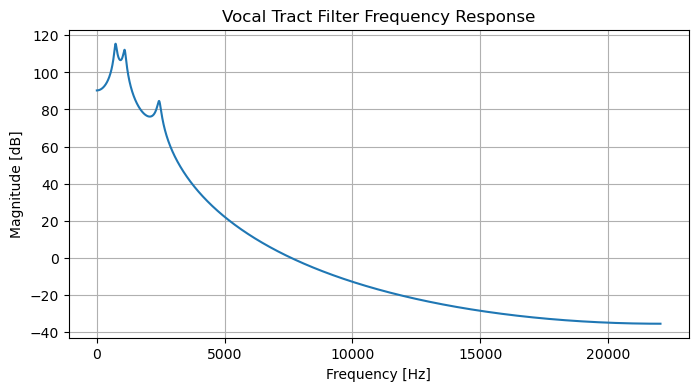

In [13]:
w, h = freqz([1.0], a_coefs, worN=8000, fs=fs)
plt.figure(figsize=(8, 4))
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title('Vocal Tract Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()


### c. Sample the Speech Signal at Different Rates (8 kHz, 16 kHz, 44.1 kHz)

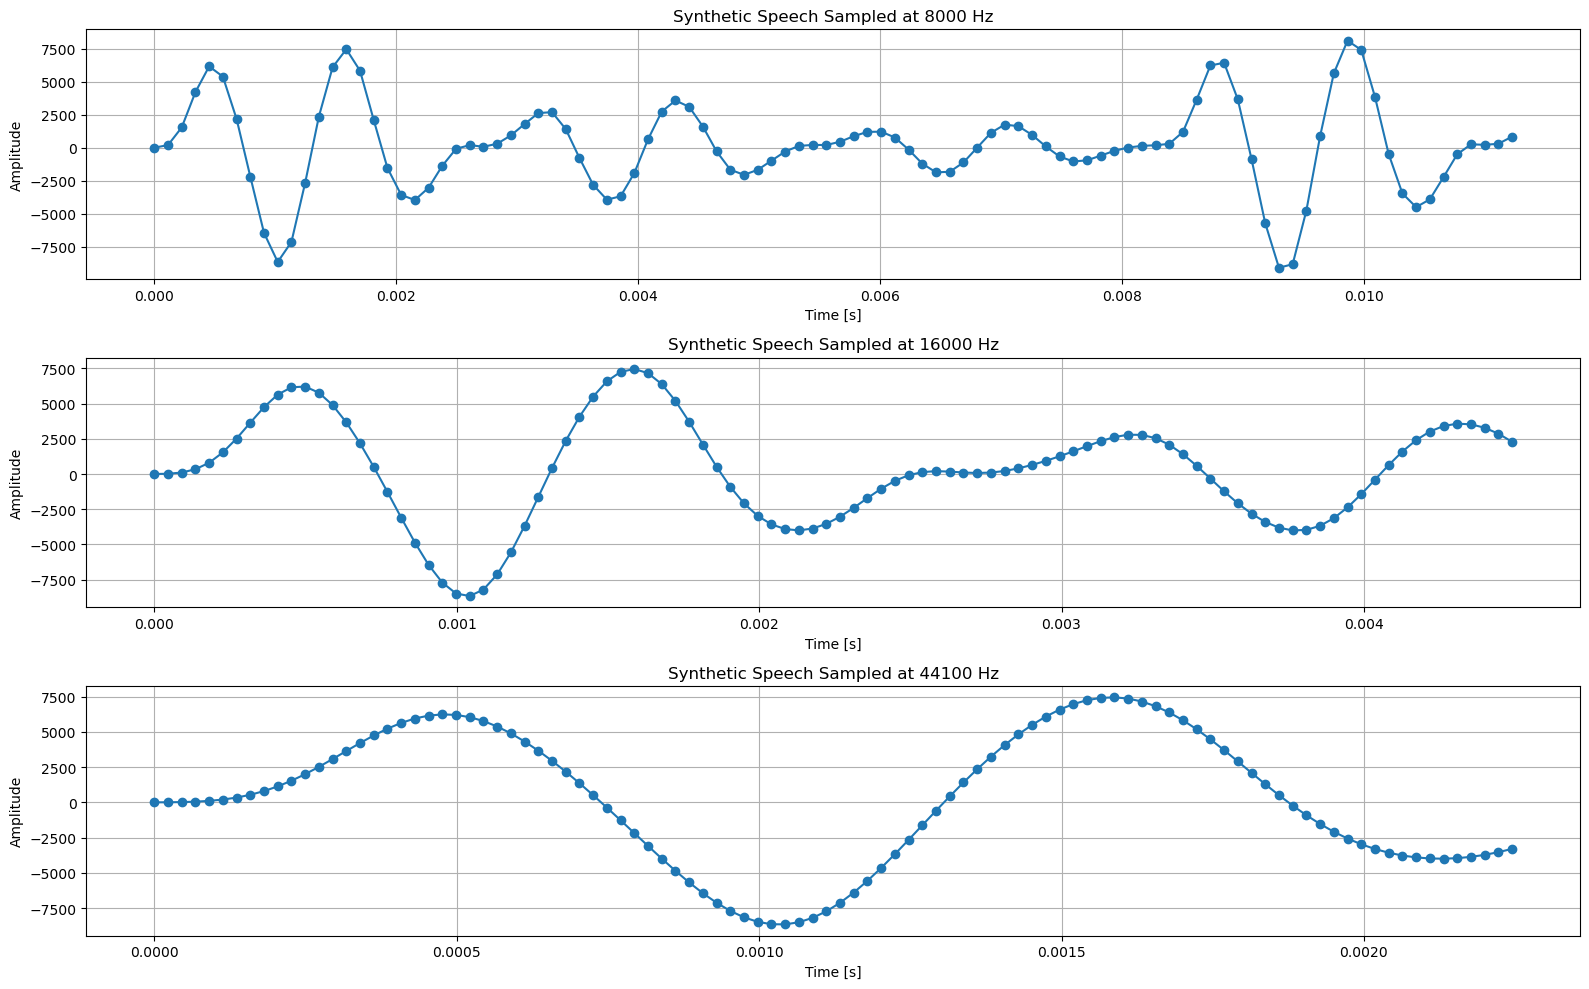

In [14]:
# Define resampling factors for target rates
target_rates = [8000, 16000, 44100]
resampled_signals = {}
resampled_times = {}

for rate in target_rates:
    idx = np.arange(0, len(synth_speech), fs // rate)
    sampled = synth_speech[idx]
    t_resampled = t[idx]
    resampled_signals[rate] = sampled
    resampled_times[rate] = t_resampled

# Plot sampled signals
plt.figure(figsize=(16, 10))
for i, rate in enumerate(target_rates):
    plt.subplot(3, 1, i+1)
    plt.plot(resampled_times[rate][:100], resampled_signals[rate][:100], 'o-')
    plt.title(f'Synthetic Speech Sampled at {rate} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()


### d. Reconstruct the Speech Signal from Sampled Versions (Linear Interpolation)


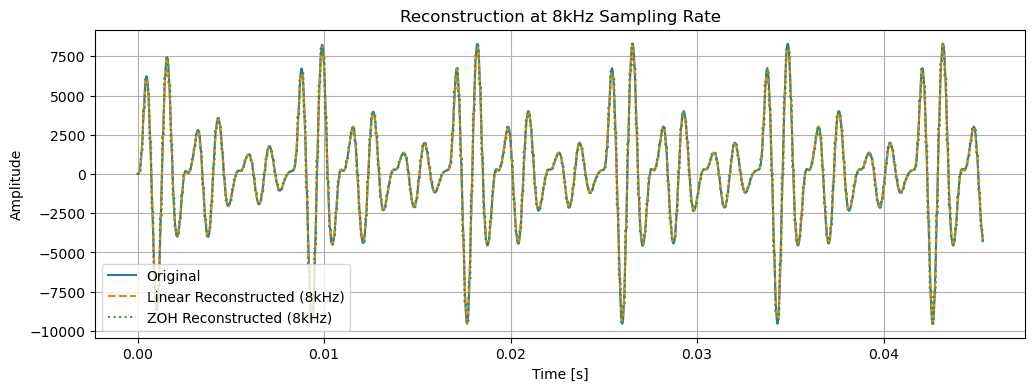

In [15]:
reconstructed_linear = {}
reconstructed_zero_order = {}
mse_linear = {}
mse_zero_order = {}

for rate in target_rates:
    # Linear interpolation
    interp_lin = interp1d(resampled_times[rate], resampled_signals[rate], kind="linear", fill_value="extrapolate")
    rec_lin = interp_lin(t)
    # Zero-order hold (nearest)
    interp_zoh = interp1d(resampled_times[rate], resampled_signals[rate], kind="nearest", fill_value="extrapolate")
    rec_zoh = interp_zoh(t)
    # Save
    reconstructed_linear[rate] = rec_lin
    reconstructed_zero_order[rate] = rec_zoh
    mse_linear[rate] = mean_squared_error(synth_speech, rec_lin)
    mse_zero_order[rate] = mean_squared_error(synth_speech, rec_zoh)

# Plot for one example rate (e.g., 8kHz)
plt.figure(figsize=(12,4))
plt.plot(t[:2000], synth_speech[:2000], label='Original')
plt.plot(t[:2000], reconstructed_linear[8000][:2000], '--', label='Linear Reconstructed (8kHz)')
plt.plot(t[:2000], reconstructed_zero_order[8000][:2000], ':', label='ZOH Reconstructed (8kHz)')
plt.title('Reconstruction at 8kHz Sampling Rate')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


#### e. Compute the Mean Squared Error (MSE) for Each Rate and Method


In [16]:
print("=== Mean Squared Error (MSE) ===")
for rate in target_rates:
    print(f"Sampling Rate: {rate} Hz")
    print(f"  - Linear Interpolation MSE:      {mse_linear[rate]:.4f}")
    print(f"  - Zero-Order Hold (Nearest) MSE: {mse_zero_order[rate]:.4f}")


=== Mean Squared Error (MSE) ===
Sampling Rate: 8000 Hz
  - Linear Interpolation MSE:      13831.4665
  - Zero-Order Hold (Nearest) MSE: 295404.5520
Sampling Rate: 16000 Hz
  - Linear Interpolation MSE:      339.6795
  - Zero-Order Hold (Nearest) MSE: 73966.4436
Sampling Rate: 44100 Hz
  - Linear Interpolation MSE:      0.0000
  - Zero-Order Hold (Nearest) MSE: 0.0000


### Inference

- **Source-filter model** successfully simulates the production of human speech by combining a periodic source (voiced sound) and resonant filtering.
- **Formant filtering (vocal tract)** shapes the spectrum, producing vowel-specific characteristics in the synthetic speech.
- **Lower sampling rates** (e.g., 8 kHz) lead to more audible distortion and less accurate reconstructions, as shown by higher MSE values, especially with ZOH (zero-order hold).
- **Linear interpolation** provides more faithful reconstructions than zero-order hold for all sampling rates.
- To preserve speech quality, you should sample above twice the highest formant frequency (Nyquist theorem) and prefer linear interpolation during reconstruction.

---
